<a href="https://colab.research.google.com/github/QiaoLin22/MASTER-LLM-DL/blob/main/text_embedding_hf_RAG_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# text_vectorization_huggingface
This notebook provides a comprehensive visualization of text vectorization and demonstrates the power of vector search in processing and understanding natural language data. Moreover, it demonstrates the main steps of RAG in a simplified format.

## Simple Retrieval Augmented Generation: (Main steps)
I. Step 1: Vectorize the user's query

II. Step 2: Perfrom vector search between the user's query and the vector database

IV. Step 3: Retrieve the top `n`` results.

V. Step 4: Prepare the LLM's input using the retrieved content and the user's query

Extra. Extra step for LLAMA: Prepare the model and its tokenizer

VI. Step 5: Pass the input to the LLM and get the response

Reference: Deeplearning.ai

In [3]:
!pip install -q -U FlagEmbedding mplcursors ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.8/161.8 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.3 MB/s eta 0:0

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
from sklearn.decomposition import PCA
from typing import List
from sklearn.metrics.pairwise import cosine_similarity
from FlagEmbedding import FlagModel
# from google.colab import output
# output.enable_custom_widget_manager()

%matplotlib ipympl

In [5]:
# Load embedding model
embedding_model = FlagModel('BAAI/bge-large-zh-v1.5',
                  query_instruction_for_retrieval="largest animal on the planet",
                  use_fp16=True
                  )
# Setting use_fp16 to True speeds up computation with a slight performance degradation

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

In [6]:
def plot_2D(x_values: List[float],
            y_values: List[float],
            labels: List[str]) -> None:
    """
    Plots a 2D scatter plot with interactive annotations.

    Parameters:
    x_values (List[float]): A list of x-coordinates for each point.
    y_values (List[float]): A list of y-coordinates for each point.
    labels (List[str]): A list of labels for each point.
    """
    # Create scatter plot
    fig, ax = plt.subplots()
    scatter = ax.scatter(x_values,
                         y_values,
                         alpha = 0.5,
                         edgecolors='k',
                         s = 40)

    # Create a mplcursors object to manage the data point interaction
    cursor = mplcursors.cursor(scatter, hover=True)

    #aes
    ax.set_title('Embedding visualization in 2D')  # Add a title
    ax.set_xlabel('X_1')  # Add x-axis label
    ax.set_ylabel('X_2')  # Add y-axis label

    # Define how each annotation should look
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(labels[sel.target.index])
        sel.annotation.get_bbox_patch().set(facecolor='white', alpha=0.5) # Set annotation's background color
        sel.annotation.set_fontsize(12)

    plt.show()

def compute_cosine_similarity(embeddings: np.ndarray, idx1: int, idx2: int) -> float:
    """
    Computes the cosine similarity between two embeddings.

    Parameters:
    embeddings (np.ndarray): An array of embeddings.
    idx1 (int): The index of the first embedding.
    idx2 (int): The index of the second embedding.

    Returns:
    float: The cosine similarity between the two embeddings.
    """
    return cosine_similarity([embeddings[idx1]],[embeddings[idx2]])[0][0]

In [7]:
animal_sen_1 = "Elephants are known for their exceptional memory and intelligence, often living in complex social structures."
animal_sen_2 = "The blue whale is the largest animal on the planet, with a heart the size of a small car."
animal_sen_3 = "Peregrine falcons are among the fastest birds, reaching over 200 miles per hour during their hunting stoop."


sport_sen_1 = "Soccer, known as football outside of North America, is the world's most popular sport, with a fan base that spans across continents."
sport_sen_2 = "The modern Olympic Games, revived in 1896, are a global event that brings together athletes from over 200 nations."
sport_sen_3 = "Serena Williams has dominated women's tennis with 23 Grand Slam singles titles, making her one of the greatest athletes of all time."


modern_society_sen_1 = "The advent of the internet has transformed modern society, enabling global connectivity and access to information at an unprecedented scale."
modern_society_sen_2 = "Climate change has become one of the most pressing issues of modern society, with a growing consensus on the need for sustainable practices."
modern_society_sen_3 = "Social media has reshaped the way we communicate and consume information, influencing everything from politics to personal relationships."


programming_sen_1 = "C++ programmers harness the power of low-level memory manipulation, crafting efficient and high-performance software for a variety of applications."
programming_sen_2 = "Java developers thrive in building platform-independent solutions, leveraging the language's 'write once, run anywhere' philosophy for versatile and scalable applications."
programming_sen_3 = "Python programmers embrace the language's readability and expressiveness, creating elegant and concise code that facilitates rapid development across diverse domains."



# combine all the examples in one list
all_input_text = [
    animal_sen_1, animal_sen_2, animal_sen_3,
    sport_sen_1, sport_sen_2, sport_sen_3,
    modern_society_sen_1, modern_society_sen_2, modern_society_sen_3,
    programming_sen_1, programming_sen_2, programming_sen_3
    ]

In [8]:
#Apply Embedding
embeddings = []
for input_text in all_input_text:
    emb = embedding_model.encode(input_text)
    embeddings.append(emb)

embeddings_array = np.array(embeddings)
print("Shape: " + str(embeddings_array.shape), "\n")
print("Sample array:", embeddings_array[0])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Shape: (12, 1024) 

Sample array: [-0.02003  -0.03125   0.00732  ... -0.02632   0.0401    0.005062]


In [9]:
# Perform PCA for reducing the dimension from 1024 to 3
PCA_model = PCA(n_components=3)
PCA_model.fit(embeddings_array)
new_values = PCA_model.transform(embeddings_array)

print("Shape: " + str(new_values.shape))
print(new_values)

Shape: (12, 3)
[[ 1.33076479e-01 -1.42211948e-05  3.93144118e-01]
 [-2.40160089e-01 -2.71866273e-01  3.82192851e-01]
 [-2.66306556e-01 -4.96981870e-01  1.92769875e-01]
 [-2.73619129e-01  2.30057853e-04 -3.07589076e-01]
 [-3.32078658e-01  1.52721369e-01 -3.21248593e-01]
 [-3.41282598e-01 -3.42156085e-01 -3.03047179e-01]
 [-8.75130665e-02  4.32335481e-01  8.18649725e-03]
 [-7.49919724e-02  3.26631075e-01  2.51158151e-01]
 [-9.48268197e-02  4.90568835e-01  5.47952473e-02]
 [ 5.04342449e-01 -1.25460571e-01 -1.22853723e-01]
 [ 6.00266934e-01 -1.01998213e-01 -7.17243368e-02]
 [ 4.73093026e-01 -6.40095833e-02 -1.55783833e-01]]


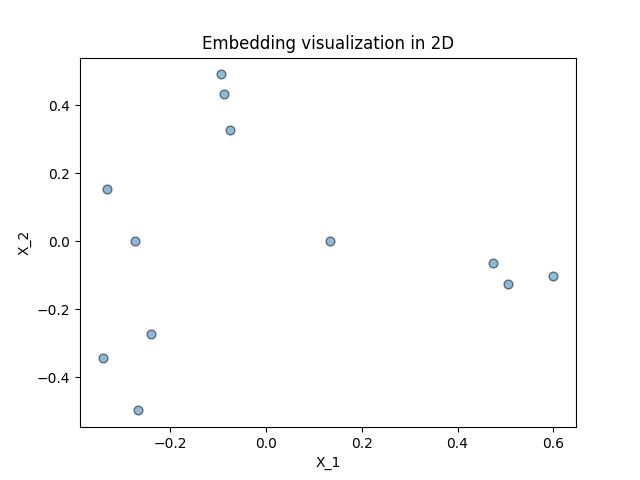

In [13]:
plot_2D(new_values[:,0], new_values[:,1], all_input_text)

In [12]:
from google.colab import output
output.enable_custom_widget_manager()

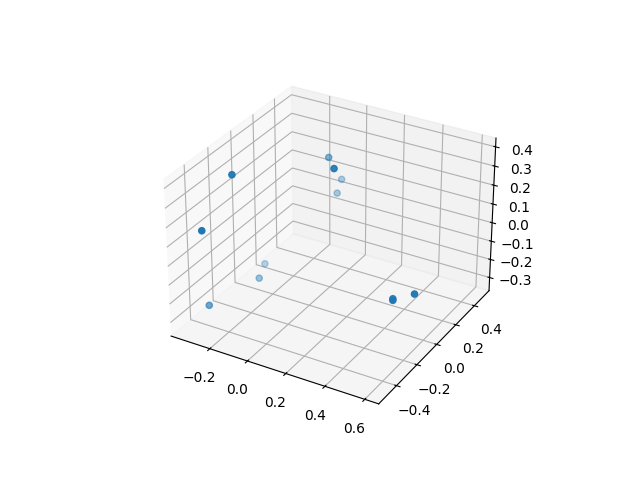

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(new_values[:, 0], new_values[:, 1], new_values[:, 2])

Computing the cosine similarity

animal_sen_1: 0, animal_sen_2: 1, animal_sen_3: 2
sport_sen_1: 3, sport_sen_2: 4, sport_sen_3: 5
modern_society_sen_1: 6, modern_society_sen_2: 7, modern_society_sen_3: 8
programming_sen_1: 9, programming_sen_2: 10, programming_sen_3: 11

In [15]:
print("animal_sen_1 vs animal_sen_2:", compute_cosine_similarity(embeddings,0,1))
print("animal_sen_1 vs programming_sen_1:", compute_cosine_similarity(embeddings,0,10))
print("sport_sen_1 vs sport_sen_2:", compute_cosine_similarity(embeddings,3,4))
print("sport_sen_1 vs programming_sen_11:", compute_cosine_similarity(embeddings,3,11))

animal_sen_1 vs animal_sen_2: 0.4777149873362028
animal_sen_1 vs programming_sen_1: 0.4458357691775449
sport_sen_1 vs sport_sen_2: 0.6136989029887909
sport_sen_1 vs programming_sen_11: 0.43009103404789295


# Simple RAG
Let's consider embeddings list to be our Vector database and search a query over it and return the results

In [17]:
# Step 1: Vectorize the user's query
query = "What are some remarkable characteristics of elephants?"
q_v = embedding_model.encode(query)
# First step: Vectorize the query
query = "What are some remarkable characteristics of elephants?"
q_v = embedding_model.encode(query)

In [18]:
# Step 2: Perfrom vector search between the user's query and the vector database
def search(embeddings:List, q_v:List)->List[float]:
    """
    Search for the cosine similarity scores between a query vector (q_v) and a list of embedding vectors.

    Parameters:
        embeddings (List[List[float]]): A list of embedding vectors.
        q_v (List[float]): The query vector for which the cosine similarity scores are calculated.

    Returns:
        List[float]: A list of cosine similarity scores between the query vector and each embedding vector.
    """
    scores = []
    for vec in embeddings:
        scores.append(cosine_similarity([vec], [q_v])[0][0])
    return scores

score_list = search(embeddings, q_v)
print(score_list)

[0.6412375118076805, 0.4577360023063456, 0.3772405945237194, 0.31037306446876384, 0.2829257113500987, 0.29409169651853073, 0.352309030404185, 0.32769187194797855, 0.30432313603287503, 0.3417511859795864, 0.29668216111029705, 0.40831973898242724]


In [19]:
# Step 3: Retrieve the top n results.
n = 3
sorted_indices = np.argsort(score_list)[::-1]
top_n_indices = sorted_indices[:n]
top_n_indices

retrieved_content = []
for i in top_n_indices:
    print(all_input_text[i], "\n")
    retrieved_content.append(all_input_text[i])

Elephants are known for their exceptional memory and intelligence, often living in complex social structures. 

The blue whale is the largest animal on the planet, with a heart the size of a small car. 

Python programmers embrace the language's readability and expressiveness, creating elegant and concise code that facilitates rapid development across diverse domains. 



# Step 4: Prepare the LLM's input using the retrieved content and the user's query

We want to Pass the retrieved content along with the user's query to a LLM to get the proper response. The role of the LLM is to see whether the retrieved content contain the answer to the user's question and provide a clean and organized response.

In [20]:
llm_system_role = "As a helpful chatbot, your role is to assist users by analyzing their questions alongside retrieved content.\
        Dispense answers exclusively from the provided content and refrain from incorporating personal knowledge if the answer is\
        absent in the retrieved information."
prompt = f"# Your role:{llm_system_role}\n\n# Retrieved content: {retrieved_content}\n\n# User's query: {query}"
print(prompt)

# Your role:As a helpful chatbot, your role is to assist users by analyzing their questions alongside retrieved content.        Dispense answers exclusively from the provided content and refrain from incorporating personal knowledge if the answer is        absent in the retrieved information.

# Retrieved content: ['Elephants are known for their exceptional memory and intelligence, often living in complex social structures.', 'The blue whale is the largest animal on the planet, with a heart the size of a small car.', "Python programmers embrace the language's readability and expressiveness, creating elegant and concise code that facilitates rapid development across diverse domains."]

# User's query: What are some remarkable characteristics of elephants?


In [21]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoModelForCausalLM,
    )
import torch
import warnings
warnings.filterwarnings("ignore")

In [22]:
# to empty GPU memory (If needed)
del embedding_model
torch.cuda.empty_cache()

In [23]:
llama_models = ["NousResearch/Llama-2-13b-chat-hf", "NousResearch/Llama-2-7b-chat-hf"]
class LlamaModel:
  def __init__(self, quant_eight=False, model="NousResearch/Llama-2-7b-chat-hf"):
    self.base_model = model
    self.quant_eight=quant_eight
    self.quant_eight_config=BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=getattr(torch, "float16"),
        bnb_8bit_use_double_quant=False,
      )
    self.llama_model = self.import_model()
    self.tokenizer_padding_side="right"
    self.tokenizer = self.import_tokenizer()
    print("\nLlama2 and its tokenizer are loaded.\n")

  def import_model(self):
    if self.quant_eight:
      print(f"Importing 8bit {self.base_model} ...\n")
      return AutoModelForCausalLM.from_pretrained(
        self.base_model,
        quantization_config=self.quant_eight_config,
        device_map={"": 0},
    )
    else:
      print(f"Importing 16b {self.base_model} ...\n")
      return AutoModelForCausalLM.from_pretrained(
        self.base_model,
        device_map={"": 0},
    )

  def import_tokenizer(self):
    print("\nImporting tokenizer ...\n")
    return AutoTokenizer.from_pretrained(self.base_model, padding_side=self.tokenizer_padding_side)


  def prepare_prompt_for_llama(self, prompt):
    prompt = f"<s>[INST] {prompt} [/INST]"
    return self.tokenizer(prompt, return_tensors="pt")

In [24]:
llama_instance = LlamaModel(quant_eight=False)

Unused kwargs: ['bnb_8bit_quant_type', 'bnb_8bit_compute_dtype', 'bnb_8bit_use_double_quant']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Importing 16b NousResearch/Llama-2-7b-chat-hf ...



config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


Importing tokenizer ...



tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]


Llama2 and its tokenizer are loaded.



In [25]:
result = llama_instance.llama_model.generate(**llama_instance.prepare_prompt_for_llama(prompt).to("cuda"), max_new_tokens=150)
print(llama_instance.tokenizer.batch_decode(result))

['<s><s>[INST] # Your role:As a helpful chatbot, your role is to assist users by analyzing their questions alongside retrieved content.        Dispense answers exclusively from the provided content and refrain from incorporating personal knowledge if the answer is        absent in the retrieved information.\n\n# Retrieved content: [\'Elephants are known for their exceptional memory and intelligence, often living in complex social structures.\', \'The blue whale is the largest animal on the planet, with a heart the size of a small car.\', "Python programmers embrace the language\'s readability and expressiveness, creating elegant and concise code that facilitates rapid development across diverse domains."]\n\n# User\'s query: What are some remarkable characteristics of elephants? [/INST]  Great! Based on the retrieved content, here are some remarkable characteristics of elephants:\n\n1. Exceptional memory: Elephants are known for their exceptional memory, which allows them to remember a

In [26]:
print(animal_sen_1)

Elephants are known for their exceptional memory and intelligence, often living in complex social structures.
